In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd './drive/My Drive/NLP/day37'

/content/drive/My Drive/NLP/day37


In [3]:
#題目:從文章題目(title)檔中用SVD得到文字的潛在語意
#說明：TruncateSVD()是用來降低文字維度到2或3維的。我們如果以在這些文章題目(title)出現的單字當作字集
#(vocabulary)，再將這些字集以文章數長度編成獨熱碼(one hot encoding)，所以維度是文章數。
#SVD將其降至低維，再用matplotlib把前兩維攤在平面上，我們可用放大鏡來檢視各個字在這些文章題目中彼此的
#距離。

#延伸:可用不同的tokenizer，不同的tokens_to_vector(count based vs frequency based vs TF-IDF)，
#不同的降維方式做改進潛在語意分布。

#範例程式檔名: lsa_潛在語意分析.py，以TruncateSVD 方式完成降維。
#模組: sklearn, matplotlib, numpy, nltk
#輸入檔：all_book_titles.txt，stopwords.txt
#成績：改變原程式(也就是延伸)但仍能達到同樣或更佳效果

from __future__ import print_function, division
from builtins import range

In [4]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD

In [5]:
nltk.download(['punkt','averaged_perceptron_tagger','wordnet'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
wordnet_lemmatizer = WordNetLemmatizer()

titles = [line.rstrip() for line in open('all_book_titles(作業數據).txt')]

# 和情緒分析用一樣的tokenizer
stopwords = set(w.rstrip() for w in open('stopwords(作業數據) (1).txt'))

# 也可嘗試以nltk處理 stopwords 的方式
# from nltk.corpus import stopwords
# stopwords.words('english')

# 增加處理這問題必要的 stopwords
stopwords = stopwords.union({
    'introduction', 'edition', 'series', 'application',
    'approach', 'card', 'access', 'package', 'plus', 'etext',
    'brief', 'vol', 'fundamental', 'guide', 'essential', 'printed',
    'third', 'second', 'fourth', })

In [7]:
from nltk.corpus import wordnet

def my_tokenizer(s):
    s = s.lower() # downcase
    tokens = nltk.word_tokenize(s) # 將字串改為tokens
    tokens = [t for t in tokens if len(t) > 2] # 去除短字
    ######################
    tokens = [t for t in tokens if t not in stopwords] # 去除 stopwords
    pos = nltk.pos_tag(tokens)
    
    token_list = []
    for t , p in (pos):
      if p.startswith('J'):
        pos = wordnet.ADJ
      elif p.startswith('V'):
        pos = wordnet.VERB
      elif p.startswith('N'):
        pos = wordnet.NOUN
      elif p.startswith('R'):
        pos = wordnet.ADV
      else:
        pos = wordnet.NOUN
      tk = wordnet_lemmatizer.lemmatize(t,pos)
      token_list.append(tk)

    tokens = [t for t in token_list if not any(c.isdigit() for c in t)] # 移除數字，比方 "3rd edition"
    return tokens

In [8]:
# 先產生 word-to-index map 再產生 word-frequency vectors
# 同時儲存 tokenized 版本未來不需再做 tokenization
word_index_map = {}
current_index = 0
all_tokens = []
all_titles = []
index_word_map = []
error_count = 0
for title in titles:
    try:
        title = title.encode('ascii', 'ignore').decode('utf-8') # this will throw exception if bad characters
        all_titles.append(title)
        tokens = my_tokenizer(title)
        all_tokens.append(tokens)
        for token in tokens:
            if token not in word_index_map:
                word_index_map[token] = current_index
                current_index += 1
                index_word_map.append(token)
    except Exception as e:
        print(e)
        print(title)
        error_count += 1


print("Number of errors parsing file:", error_count, "number of lines in file:", len(titles))
if error_count == len(titles):
    print("There is no data to do anything with! Quitting...")

Number of errors parsing file: 0 number of lines in file: 2373


In [9]:
# 產生輸入矩陣 - 是否出現(indicator)較比例(proportions)更準
def tokens_to_vector(tokens):
    x = np.zeros(len(word_index_map))
    for t in tokens:
        i = word_index_map[t]
        x[i] = 1
    return x

In [10]:
N = len(all_tokens)
D = len(word_index_map)
X = np.zeros((D, N)) # 字彙是列, 文件是行
i = 0
for tokens in all_tokens:
    X[:,i] = tokens_to_vector(tokens)
    i += 1

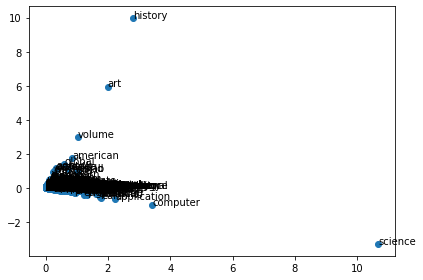

In [16]:
def main():
    svd = TruncatedSVD()
    Z = svd.fit_transform(X)
    # ref:https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-x-or-y-axis-in-matplotlib
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(D):
        plt.annotate(s=index_word_map[i], xy=(Z[i,0], Z[i,1]))
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()
